In [24]:
import csv
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

In [25]:
DS = pd.read_csv("ObjectSubset150SentenceLength.csv")

In [26]:
DS['tag'].fillna('O', inplace=True)

In [27]:
words = list(set(DS["word"].values))
n_words = len(words)
n_words

27741

In [28]:
tags = list(set(DS["tag"].values))
n_tags = len(tags); n_tags


2

In [37]:
tags

['O', 'object']

In [29]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("text_ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [30]:
getter = SentenceGetter(DS)

In [31]:
sentences = getter.sentences


In [32]:
labels = [[s[1] for s in sent] for sent in sentences]
sentences = [" ".join([s[0] for s in sent]) for sent in sentences]
sentences[0]


'26.05.09 patsient hospitaliseeritud erütrotsüütide ülekandeks, 2 doosi RR 120/85 temperatuur 37.7. Võetud vereanalüüsid. Enesetunne rahuldav.'

In [93]:
print(labels[0])


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'object', 'object', 'O', 'O', 'O', 'O', 'O', 'O']


In [33]:
from collections import Counter
from keras.preprocessing.sequence import pad_sequences

word_cnt = Counter(DS["word"].values)
vocabulary = set(w[0] for w in word_cnt.most_common(5000))


In [34]:
max_len = 50
word2idx = {"PAD": 0, "UNK": 1}
word2idx.update({w: i for i, w in enumerate(words) if w in vocabulary})
tag2idx = {t: i for i, t in enumerate(tags)}


In [56]:
idx2word = {i: w for w, i in word2idx.items()}

In [35]:
X = [[word2idx.get(w, word2idx["UNK"]) for w in s.split()] for s in sentences]


In [39]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["PAD"])


In [40]:
y = [[tag2idx[l_i] for l_i in l] for l in labels]


In [41]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])


In [42]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, shuffle=False)


In [43]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, SpatialDropout1D, Bidirectional


In [44]:
word_input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(word_input)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)


In [45]:
model = Model(word_input, out)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [46]:
history = model.fit(X_tr, y_tr.reshape(*y_tr.shape, 1),
                    batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)


C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11050 samples, validate on 1228 samples
Epoch 1/5
11050/11050 [==============================] - 24s 2ms/step - loss: 0.0384 - accuracy: 0.9889 - val_loss: 0.0207 - val_accuracy: 0.9942
Epoch 2/5
11050/11050 [==============================] - 23s 2ms/step - loss: 0.0099 - accuracy: 0.9970 - val_loss: 0.0146 - val_accuracy: 0.9951
Epoch 3/5
11050/11050 [==============================] - 23s 2ms/step - loss: 0.0080 - accuracy: 0.9975 - val_loss: 0.0152 - val_accuracy: 0.9952
Epoch 4/5
11050/11050 [==============================] - 23s 2ms/step - loss: 0.0071 - accuracy: 0.9978 - val_loss: 0.0138 - val_accuracy: 0.9955
Epoch 5/5
11050/11050 [==============================] - 23s 2ms/step - loss: 0.0066 - accuracy: 0.9980 - val_loss: 0.0116 - val_accuracy: 0.9963


In [ ]:
# from keras.callbacks import ModelCheckpoint

# # Saving the best model only
# filepath="CharacterEmbeddingObject-{val_accuracy:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

In [47]:
hist = pd.DataFrame(history.history)


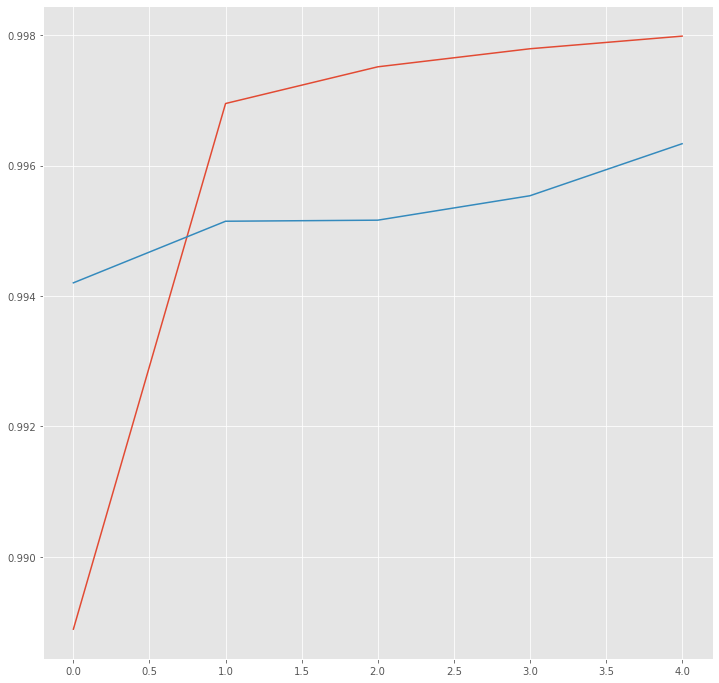

In [49]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()


In [51]:
y_pred = model.predict(X_te)

In [53]:
idx2tag = {i: w for w, i in tag2idx.items()}

In [60]:
i = 1006
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], y_te[i], p):
    if t != 0: #PAD
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
RR             : object object
130/80,        : object object


In [ ]:
len(y_pred)

### Wrong Tags


In [64]:
j = 0
for i in range(len(y_pred)):
    p = np.argmax(y_pred[i], axis=-1)
#     print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
#     print(30 * "=")
    for w, t, pred in zip(X_te[i], y_te[i], p):
        if idx2word[w] != "": #PAD
            if idx2tag[t] != idx2tag[pred]:
                print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))
                j = j+1


UNK            : object O
UNK            : O     object
UNK            : object O
UNK            : O     object
UNK            : object O
UNK            : object O
UNK            : object O
112/70         : O     object
UNK            : O     object
UNK            : object O
UNK            : object O
UNK            : O     object
UNK            : object O
120/85         : object O
kontrolli,     : O     object
RR120/70mmHg   : object O
pigem          : O     object
RR140/90       : object O
UNK            : object O
UNK            : object O
kontroll       : O     object
UNK            : object O
UNK            : O     object
UNK            : object O
UNK            : object O
UNK            : object O
UNK            : object O
UNK            : object O
UNK            : object O
UNK            : object O
UNK            : object O
UNK            : object O
UNK            : object O
UNK            : O     object
UNK            : object O
UNK            : object O
UNK            : object 

In [65]:
j

314

In [66]:
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "text"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PAD", "text"))
        out.append(out_i)
    return out

pred_labels = pred2label(y_pred)
test_labels = test2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))


F1-score: 87.2%
           precision    recall  f1-score   support

   object       0.92      0.83      0.87      1519

micro avg       0.92      0.83      0.87      1519
macro avg       0.92      0.83      0.87      1519



In [67]:
accuracy_score(test_labels, pred_labels)

0.9953992673992674

In [68]:
from sklearn_crfsuite.metrics import flat_classification_report,flat_accuracy_score
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)
print("Accuracy",flat_accuracy_score(y_pred=pred_labels, y_true=test_labels))

              precision    recall  f1-score   support

           O       1.00      1.00      1.00     65536
      object       0.97      0.91      0.94      2714

    accuracy                           1.00     68250
   macro avg       0.98      0.95      0.97     68250
weighted avg       1.00      1.00      1.00     68250

Accuracy 0.9953992673992674


## Interpretability
###### TextExplainer allows to explain predictions of black-box text classifiers using LIME algorithm.



In [69]:
from eli5.lime import TextExplainer
from eli5.lime.samplers import MaskingTextSampler
# https://eli5.readthedocs.io/en/latest/autodocs/lime.html

C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [70]:
class NERExplainerGenerator(object):
    
    def __init__(self, model, word2idx, tag2idx, max_len):
        self.model = model
        self.word2idx = word2idx
        self.tag2idx = tag2idx
        self.idx2tag = {v: k for k,v in tag2idx.items()}
        self.max_len = max_len
        
    def _preprocess(self, texts):
        X = [[self.word2idx.get(w, self.word2idx["UNK"]) for w in t.split()]
             for t in texts]
        X = pad_sequences(maxlen=self.max_len, sequences=X,
                          padding="post", value=self.word2idx["PAD"])
        return X
    
    def get_predict_function(self, word_index):
        def predict_func(texts):
            X = self._preprocess(texts)
            p = self.model.predict(X)
            return p[:,word_index,:]
        return predict_func


In [320]:
Sentneceindex = 21
label = labels[20:24]
text = sentences[20:24]
# print(label)
# print(text)

text = " ".join(str(x) for x in text)
label = [' '.join(x) for x in label]
label = " ".join(str(x) for x in label)
# print(label)
# print(text)
# # # label = [' '.join(x) for x in label]
# label = " ".join(str(x) for x in label)

# print(label)
print(" ".join([f"{t} ({l})" for t, l in zip(text.split(), label.split())]))


Põhjendus: (O) 6A (O) dünaamikas (O) Kirjeldus: (O) Võrreldes (O) 23.10 (O) tehtud (O) ü/v-ga (O) dünaamika (O) puudub. (O) Pikkus-165, (object) kaal-107,6. (O) v/s-10,5 (O) tühjalt. (O) 29.04.2013 (O) - (O) RR (object) 120/80 (object) mmHg.fr.70 (O) x/min.O2 (O) saturatsioon (O) 100 (O) %,kaal (O) 63 (O) kg.pikkus (O) 168 (O) cm. (O) . (O) Cor (O) toonid (O) arütmilised. (O) Frekvents (O) 87x (O) minutis (O) .RR110/78 (object) mmhg (O) Turseid (O) ei (O) ole (O) . (O) Biokeemia (O) tehtud (O) perearsti (O) poolt (O) . (O)


In [274]:
for i, w in enumerate(text.split()):
    print(f"{i}: {w}")


0: Põhjendus:
1: 6A
2: dünaamikas
3: Kirjeldus:
4: Võrreldes
5: 23.10
6: tehtud
7: ü/v-ga
8: dünaamika
9: puudub.
10: Pikkus-165,
11: kaal-107,6.
12: v/s-10,5
13: tühjalt.
14: 29.04.2013
15: -
16: RR
17: 120/80
18: mmHg.fr.70
19: x/min.O2
20: saturatsioon
21: 100
22: %,kaal
23: 63
24: kg.pikkus
25: 168
26: cm.
27: .
28: Cor
29: toonid
30: arütmilised.
31: Frekvents
32: 87x
33: minutis
34: .RR110/78
35: mmhg
36: Turseid
37: ei
38: ole
39: .
40: Biokeemia
41: tehtud
42: perearsti
43: poolt
44: .


In [275]:
explainer_generator = NERExplainerGenerator(model, word2idx, tag2idx, max_len)


In [276]:
word_index = 16
predict_func = explainer_generator.get_predict_function(word_index=word_index)


In [322]:
sampler = MaskingTextSampler(
    replacement="UNK",
    max_replace=0.7,
    token_pattern=None,
    bow=False
)
print(sampler.sample_near(text, n_samples=10))


(('UNK: UNK UNK Kirjeldus: UNK 23.UNK tehtud ü/v-ga UNK UNK. Pikkus-UNK, UNK-107,UNK. UNK/UNK-UNK,UNK tühjalt. 29.UNK.UNK - UNK UNK/UNK UNK.UNK.UNK UNK/UNK.UNK saturatsioon UNK %,kaal UNK kg.UNK UNK UNK. . Cor UNK UNK. Frekvents 87x minutis .UNK/UNK UNK UNK ei UNK . UNK UNK UNK UNK .', 'UNK: 6A dünaamikas Kirjeldus: UNK UNK.10 UNK ü/v-ga dünaamika puudub. Pikkus-165, kaal-107,UNK. v/s-10,UNK tühjalt. UNK.04.2013 - RR 120/80 UNK.fr.70 x/min.UNK saturatsioon UNK %,kaal 63 kg.UNK UNK UNK. . Cor toonid UNK. UNK UNK minutis .RR110/78 mmhg Turseid ei ole . Biokeemia tehtud perearsti poolt .', 'Põhjendus: 6A UNK Kirjeldus: Võrreldes 23.UNK UNK ü/v-ga dünaamika puudub. UNK-UNK, kaal-UNK,6. UNK/UNK-UNK,5 tühjalt. UNK.UNK.2013 - RR UNK/80 mmHg.UNK.UNK UNK/min.O2 UNK 100 %,kaal 63 kg.pikkus UNK cm. . UNK UNK UNK. Frekvents 87x minutis .UNK/78 UNK UNK UNK UNK . UNK UNK UNK UNK .', 'Põhjendus: 6A dünaamikas UNK: UNK UNK.UNK tehtud UNK/UNK-ga UNK UNK. Pikkus-165, UNK-UNK,UNK. UNK/UNK-10,UNK UNK. UNK

In [321]:
te = TextExplainer(
    sampler=sampler,
    position_dependent=True,
    random_state=42,
#     char_based =True #True if explanation should be char-based, False if it should be token-based. Default is False.
)

te.fit(text, predict_func)

te.explain_prediction(
    target_names=list(explainer_generator.idx2tag.values())
   
)
# https://github.com/TeamHG-Memex/eli5/blob/017c738f8dcf3e31346de49a390835ffafad3f1b/eli5/explain.py#L83


Explanation(estimator="SGDClassifier(alpha=0.001, average=False, class_weight=None,\n              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,\n              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,\n              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',\n              power_t=0.5, random_state=RandomState(MT19937) at 0x1BB731FF8C8,\n              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,\n              warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='O', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=2.851643737859112, std=None, value=1.0), FeatureWeight(feature='[7] tehtud', weight=1.2495042699178953, std=None, value=1.0), FeatureWeight(feature='[3] Kirjeldus', weight=0.6804731518974096, std=None, value=1.0), FeatureWeight(feature='[0] Põhjendus', weight=0.3769812724879292, std=None, value=1.0), FeatureWeight(feature='[1] 6A', weight=0.2684663774371928, std=None, value=1.0), FeatureWeight(feature='[9] v', weight=0.150151117388824, std=None, value=1.0), FeatureWeight(feature='[16] 107', weight=0.14827220149004874, std=None, value=1.0), FeatureWeight(feature='[2] dünaamikas', weight=0.13602161420781608, std=None, value=1.0), FeatureWeight(feature='[44] toonid', weight=0.13562437039552117, std=None, value=1.0), FeatureWeight(feature='[50] 78', weight=0.1291547003316592, std=None, value=1.0), FeatureWeight(feature='[5] 23', weight=0.1232329967958402, std=None, value=1.0), FeatureWeight(feature='[10] ga', weight=0.11859687270860182, std=None, value=1.0), FeatureWeight(feature='[25] 2013', weight=0.10439633251366834, std=None, value=1.0), FeatureWeight(feature='[57] perearsti', weight=0.10300275370797378, std=None, value=1.0), FeatureWeight(feature='[47] 87x', weight=0.09320295573963731, std=None, value=1.0), FeatureWeight(feature='[4] Võrreldes', weight=0.09174117512114939, std=None, value=1.0), FeatureWeight(feature='[13] Pikkus', weight=0.0916241536139618, std=None, value=1.0), FeatureWeight(feature='[37] kaal', weight=0.07192800020584722, std=None, value=1.0), FeatureWeight(feature='[52] Turseid', weight=0.06213412296282621, std=None, value=1.0), FeatureWeight(feature='[54] ole', weight=0.048658440116193906, std=None, value=1.0), FeatureWeight(feature='[23] 29', weight=0.04331267887179339, std=None, value=1.0), FeatureWeight(feature='[26] RR', weight=0.042784223339383566, std=None, value=1.0), FeatureWeight(feature='[45] arütmilised', weight=0.041685424103230645, std=None, value=1.0), FeatureWeight(feature='[53] ei', weight=0.04105305764213442, std=None, value=1.0), FeatureWeight(feature='[14] 165', weight=0.038361983739905146, std=None, value=1.0), FeatureWeight(feature='[43] Cor', weight=0.03500564880452398, std=None, value=1.0), FeatureWeight(feature='[17] 6', weight=0.013341748167969467, std=None, value=1.0)], neg=[FeatureWeight(feature='[12] puudub', weight=-0.08296536588060886, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.9992594599421792, score=-7.207390015687441, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='Põhjendus: 6A dünaamikas Kirjeldus: Võrreldes 23.10 tehtud ü/v-ga dünaamika puudub. Pikkus-165, kaal-107,6. v/s-10,5 tühjalt. 29.04.2013 - RR 120/80 mmHg.fr.70 x/min.O2 saturatsioon 100 %,kaal 63 kg.pikkus 168 cm. . Cor toonid arütmilised. Frekvents 87x minutis .RR110/78 mmhg Turseid ei ole . Biokeemia tehtud perearsti poolt .', spans=[('Põhjendus', [(0, 9)], 0.3769812724879292), ('6A', [(11, 13)], 0.2684663774371928), ('dünaamikas', [(14, 24)], 0.13602161420781608), ('Kirjeldus', [(25, 34)], 0.6804731518974096), ('Võrreldes', [(36, 45)], 0.09174117512114939), ('23', [(46, 48)], 0.1232329967958402), ('tehtud', [(52, 58)], 1.2495042699178953), ('v', [(61, 62)], 0.150151117388824), ('ga', [(63, 65)], 0.11859687270860182), ('puudub', [(76, 82)], -0.08296536588060886), ('Pikkus', [(8

In [323]:
label = labels[196:201]
text = sentences[196:201]
text = " ".join(str(x) for x in text)
label = [' '.join(x) for x in label]
label = " ".join(str(x) for x in label)
print(text)
print(" ".join([f"{t} ({l})" for t, l in zip(text.split(), label.split())]))


Üldseisund: rahuldav 156 cm,90 kg Kardiovaskulaarsüsteem: RR 140/80 mmHg,fr reg 72 x min RR130/100 mmHg. Obj. liigesturset ei ole, k.a. MTP-des. RR 160/80 mmHg, kaal 131,1 kg, eutüreoidne, kilpnääre palp.tundub veidi tihedam normist, võimalik nodoosne.
Üldseisund: (O) rahuldav (O) 156 (O) cm,90 (O) kg (O) Kardiovaskulaarsüsteem: (O) RR (object) 140/80 (object) mmHg,fr (O) reg (O) 72 (O) x (O) min (O) RR130/100 (object) mmHg. (O) Obj. (O) liigesturset (O) ei (O) ole, (O) k.a. (O) MTP-des. (O) RR (object) 160/80 (object) mmHg, (O) kaal (O) 131,1 (O) kg, (O) eutüreoidne, (O) kilpnääre (O) palp.tundub (O) veidi (O) tihedam (O) normist, (O) võimalik (O) nodoosne. (O)


In [324]:
for i, w in enumerate(text.split()):
    print(f"{i}: {w}")

0: Üldseisund:
1: rahuldav
2: 156
3: cm,90
4: kg
5: Kardiovaskulaarsüsteem:
6: RR
7: 140/80
8: mmHg,fr
9: reg
10: 72
11: x
12: min
13: RR130/100
14: mmHg.
15: Obj.
16: liigesturset
17: ei
18: ole,
19: k.a.
20: MTP-des.
21: RR
22: 160/80
23: mmHg,
24: kaal
25: 131,1
26: kg,
27: eutüreoidne,
28: kilpnääre
29: palp.tundub
30: veidi
31: tihedam
32: normist,
33: võimalik
34: nodoosne.


In [325]:
word_index = 6
predict_func = explainer_generator.get_predict_function(word_index=word_index)
te = TextExplainer(
    random_state=1,
)

te.fit(text, predict_func)

te.explain_prediction(
    target_names=list(explainer_generator.idx2tag.values())
   
)

Explanation(estimator="SGDClassifier(alpha=0.001, average=False, class_weight=None,\n              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,\n              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,\n              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',\n              power_t=0.5, random_state=RandomState(MT19937) at 0x1BB79A25AE8,\n              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,\n              warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='object', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='rr 140', weight=1.7579670446691162, std=None, value=1.0), FeatureWeight(feature='rahuldav 156', weight=1.649968752914558, std=None, value=1.0), FeatureWeight(feature='kardiovaskulaarsüsteem rr', weight=1.628702738446266, std=None, value=1.0), FeatureWeight(feature='90 kg', weight=1.54798896869651, std=None, value=1.0), FeatureWeight(feature='kg kardiovaskulaarsüsteem', weight=1.3960012172283318, std=None, value=1.0), FeatureWeight(feature='üldseisund rahuldav', weight=1.0901163356605912, std=None, value=1.0), FeatureWeight(feature='156 cm', weight=0.9904540895956094, std=None, value=1.0), FeatureWeight(feature='rr', weight=0.8800061809386556, std=None, value=2.0), FeatureWeight(feature='kg', weight=0.7334275946516182, std=None, value=2.0), FeatureWeight(feature='rahuldav', weight=0.6133999487702116, std=None, value=1.0), FeatureWeight(feature='reg 72', weight=0.5989501354293613, std=None, value=1.0), FeatureWeight(feature='liigesturset ei', weight=0.5781045832603571, std=None, value=1.0), FeatureWeight(feature='140 80', weight=0.571449794144677, std=None, value=1.0), FeatureWeight(feature='156', weight=0.5453628475891014, std=None, value=1.0), FeatureWeight(feature='võimalik nodoosne', weight=0.5292761972951903, std=None, value=1.0), FeatureWeight(feature='tundub veidi', weight=0.37584626918104747, std=None, value=1.0), FeatureWeight(feature='x min', weight=0.3677521242165682, std=None, value=1.0), FeatureWeight(feature='rr130', weight=0.36735382699821695, std=None, value=1.0), FeatureWeight(feature='100 mmhg', weight=0.3562058395455324, std=None, value=1.0), FeatureWeight(feature='mmhg fr', weight=0.3546028418893001, std=None, value=1.0), FeatureWeight(feature='mmhg kaal', weight=0.3526098437537956, std=None, value=1.0), FeatureWeight(feature='mtp des', weight=0.3182386111144814, std=None, value=1.0), FeatureWeight(feature='normist võimalik', weight=0.3071554788691502, std=None, value=1.0), FeatureWeight(feature='ei ole', weight=0.2827060846587643, std=None, value=1.0), FeatureWeight(feature='tihedam normist', weight=0.2766436203628976, std=None, value=1.0), FeatureWeight(feature='72 x', weight=0.2705064443989024, std=None, value=1.0), FeatureWeight(feature='obj liigesturset', weight=0.26142055552172966, std=None, value=1.0), FeatureWeight(feature='kilpnääre palp', weight=0.2609314258771324, std=None, value=1.0), FeatureWeight(feature='131 1', weight=0.24998294713363242, std=None, value=1.0), FeatureWeight(feature='k a', weight=0.24666880111107525, std=None, value=1.0), FeatureWeight(feature='80 mmhg', weight=0.23543157269789852, std=None, value=2.0), FeatureWeight(feature='fr reg', weight=0.20233119215050974, std=None, value=1.0), FeatureWeight(feature='palp tundub', weight=0.19554473672928124, std=None, value=1.0), FeatureWeight(feature='mmhg obj', weight=0.19128899413442965, std=None, value=1.0), FeatureWeight(feature='160 80', weight=0.18925863225148473, std=None, value=1.0), FeatureWeight(feature='kg eutüreoidne', weight=0.18598377197333535, std=None, value=1.0), FeatureWeight(feature='veidi tihedam', weight=0.17047054881630233, std=None, value=1.0), FeatureWeight(feature='rr130 100', weight=0.15936944939560285, std=None, value=1.0), FeatureWeight(feature='ole k', weight=0.15770090930316763, std=None, value=1.0), FeatureWeight(feature='kaal 131', wei

In [348]:
sampler = MaskingTextSampler(
    replacement="UNK",
    max_replace=0.7,
    token_pattern=None,
    bow=False
)
print(sampler.sample_near(text, n_samples=5))


(('Cor toonid regulaarsed . kerge süstoolne kahin . EKG regulaarne siinusrütm . Vasema vatsakese hüpertroofia . UNK 150/ 90 UNK.06.2012 - KMI 38,77, kaal 127 kg. RR UNK/100 mmHg. Kilpnääre II astmes, sõlmedega, kahinata, valutu. Jalgadel laienenud kapillaarid. . 02.02.2012 - Kaal UNK UNK 120/80mmHg Cor regul 64xmin. perif turseid ei ole. Abdominaalne rasvumine. TSH 1,34. . 29.08.2012:', 'UNK toonid regulaarsed . kerge süstoolne UNK . EKG regulaarne siinusrütm . UNK vatsakese hüpertroofia . RR 150/ 90 27.06.2012 - KMI 38,UNK, kaal 127 UNK. RR UNK/UNK mmHg. Kilpnääre II astmes, UNK, kahinata, valutu. Jalgadel laienenud kapillaarid. . 02.UNK.UNK - UNK UNK RR 120/80mmHg UNK regul 64xmin. UNK UNK ei ole. Abdominaalne rasvumine. TSH 1,34. . 29.08.2012:', 'UNK UNK UNK . UNK UNK UNK . UNK regulaarne UNK . UNK vatsakese hüpertroofia . UNK UNK/ 90 UNK.UNK.2012 - UNK UNK,UNK, UNK UNK UNK. UNK 150/UNK UNK. Kilpnääre UNK UNK, UNK, kahinata, UNK. UNK laienenud UNK. . UNK.02.UNK - UNK 98kg UNK 120/80

In [347]:
label = labels[105:109]
text = sentences[105:109]
text = " ".join(str(x) for x in text)
label = [' '.join(x) for x in label]
label = " ".join(str(x) for x in label)
print(text)
print(" ".join([f"{t} ({l})" for t, l in zip(text.split(), label.split())]))

for i, w in enumerate(text.split()):
    print(f"{i}: {w}")
    
word_index =26
predict_func = explainer_generator.get_predict_function(word_index=word_index)

te = TextExplainer(
    sampler=sampler,
    position_dependent=True,
    random_state=1,
#     char_based =True #True if explanation should be char-based, False if it should be token-based. Default is False.
)

te.fit(text, predict_func)

te.explain_prediction(
    target_names=list(explainer_generator.idx2tag.values())
   
)

Cor toonid regulaarsed . kerge süstoolne kahin . EKG regulaarne siinusrütm . Vasema vatsakese hüpertroofia . RR 150/ 90 27.06.2012 - KMI 38,77, kaal 127 kg. RR 150/100 mmHg. Kilpnääre II astmes, sõlmedega, kahinata, valutu. Jalgadel laienenud kapillaarid. . 02.02.2012 - Kaal 98kg RR 120/80mmHg Cor regul 64xmin. perif turseid ei ole. Abdominaalne rasvumine. TSH 1,34. . 29.08.2012:
Cor (O) toonid (O) regulaarsed (O) . (O) kerge (O) süstoolne (O) kahin (O) . (O) EKG (O) regulaarne (O) siinusrütm (O) . (O) Vasema (O) vatsakese (O) hüpertroofia (O) . (O) RR (object) 150/ (object) 90 (O) 27.06.2012 (O) - (O) KMI (O) 38,77, (O) kaal (O) 127 (O) kg. (O) RR (object) 150/100 (object) mmHg. (O) Kilpnääre (O) II (O) astmes, (O) sõlmedega, (O) kahinata, (O) valutu. (O) Jalgadel (O) laienenud (O) kapillaarid. (O) . (O) 02.02.2012 (O) - (O) Kaal (O) 98kg (O) RR (object) 120/80mmHg (object) Cor (O) regul (O) 64xmin. (O) perif (O) turseid (O) ei (O) ole. (O) Abdominaalne (O) rasvumine. (O) TSH (O) 1,34

Explanation(estimator="SGDClassifier(alpha=0.001, average=False, class_weight=None,\n              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,\n              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,\n              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',\n              power_t=0.5, random_state=RandomState(MT19937) at 0x1BB731FF8C8,\n              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,\n              warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='O', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='[33] valutu', weight=2.184242719103973, std=None, value=1.0), FeatureWeight(feature='<BIAS>', weight=1.9628294429127104, std=None, value=1.0), FeatureWeight(feature='[27] mmHg', weight=0.5433820658751116, std=None, value=1.0), FeatureWeight(feature='[24] RR', weight=0.4949546378952012, std=None, value=1.0), FeatureWeight(feature='[32] kahinata', weight=0.2632544206217954, std=None, value=1.0), FeatureWeight(feature='[29] II', weight=0.22715817510002065, std=None, value=1.0), FeatureWeight(feature='[28] Kilpnääre', weight=0.18587953733543655, std=None, value=1.0), FeatureWeight(feature='[57] 29', weight=0.13824012982467873, std=None, value=1.0), FeatureWeight(feature='[16] 06', weight=0.13275341573975807, std=None, value=1.0), FeatureWeight(feature='[44] 80mmHg', weight=0.1072328779149954, std=None, value=1.0), FeatureWeight(feature='[42] RR', weight=0.10372598122700454, std=None, value=1.0), FeatureWeight(feature='[25] 150', weight=0.08999337345395425, std=None, value=1.0), FeatureWeight(feature='[48] perif', weight=0.08833549359763983, std=None, value=1.0), FeatureWeight(feature='[45] Cor', weight=0.08753253234463933, std=None, value=1.0), FeatureWeight(feature='[21] kaal', weight=0.07997006578756874, std=None, value=1.0), FeatureWeight(feature='[55] 1', weight=0.07414292286323476, std=None, value=1.0), FeatureWeight(feature='[41] 98kg', weight=0.07272340013501176, std=None, value=1.0), FeatureWeight(feature='[37] 02', weight=0.06212094826895249, std=None, value=1.0), FeatureWeight(feature='[26] 100', weight=0.06026566547441532, std=None, value=1.0), FeatureWeight(feature='[6] EKG', weight=0.04579111630145259, std=None, value=1.0), FeatureWeight(feature='[54] TSH', weight=0.04190584455664974, std=None, value=1.0), FeatureWeight(feature='[15] 27', weight=0.04180123449906112, std=None, value=1.0), FeatureWeight(feature='[12] RR', weight=0.03827291360076936, std=None, value=1.0), FeatureWeight(feature='[52] Abdominaalne', weight=0.02291671981145091, std=None, value=1.0), FeatureWeight(feature='[4] süstoolne', weight=0.01595176715366844, std=None, value=1.0), FeatureWeight(feature='[59] 2012', weight=0.01473565759509571, std=None, value=1.0)], neg=[FeatureWeight(feature='[35] laienenud', weight=-0.45853211991525167, std=None, value=1.0), FeatureWeight(feature='[30] astmes', weight=-0.23864879679831716, std=None, value=1.0), FeatureWeight(feature='[40] Kaal', weight=-0.05366076219081095, std=None, value=1.0), FeatureWeight(feature='[34] Jalgadel', weight=-0.005788023982564124, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.9983796369232394, score=-6.4234833561073055, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='Cor toonid regulaarsed . kerge süstoolne kahin . EKG regulaarne siinusrütm . Vasema vatsakese hüpertroofia . RR 150/ 90 27.06.2012 - KMI 38,77, kaal 127 kg. RR 150/100 mmHg. Kilpnääre II astmes, sõlmedega, kahinata, valutu. Jalgadel laienenud kapillaarid. . 02.02.2012 - Kaal 98kg RR 120/80mmHg Cor regul 64xmin. perif turseid ei ole. Abdominaalne rasvumine. TSH 1,34. . 29.08.2012:', spans=[('süstoolne', [(31, 40)], 0.01595176715366844), ('EKG', [(49, 52)], 0.04579111630145259), ('RR', [(109, 111)], 0.03827291360076936), ('27', [(120, 122)], 0.04180123449906112), ('06', [(123, 125)], 0.13275341573975807), ('ka

In [335]:
te.metrics_


{'mean_KL_divergence': 0.020141607496157836, 'score': 0.9689993641457333}

In [336]:
te.clf

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=RandomState(MT19937) at 0x1BB798A87B8,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [349]:
te.vec_

SingleDocumentVectorizer(token_pattern='(?u)\\b\\w+\\b')

#### In this example both accuracy and KL divergence are good; it means our white-box classifier usually assigns the same labels as the black-box classifier on the dataset we generated, and its predicted probabilities are close to those predicted by our NN model. So it is likelythat the explanation is correct and can be trusted.